In [53]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date,datetime,timedelta
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error,confusion_matrix, roc_curve, auc,classification_report,confusion_matrix,accuracy_score
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.utils import plot_model
import seaborn as sns
from keras import backend as K
import warnings
warnings.filterwarnings('ignore')

#### Input params ##################
stk_path = r"C:\Users\USER\PycharmProjects\tf2\models\DL\dataset\Qingdao_SH-partial.csv"
test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set

num_feature=4 # pre_close

######### param. initial value ############
N = 5                          
lstm_units=50                  
dropout_prob=0.1               
optimizer='adam'               
epochs=10                      
batch_size=1                   
############################################


model_seed = 100
fontsize = 14
ticklabelsize = 14
####################################

# Set seeds to ensure same output results
seed(101)
set_random_seed(model_seed)


import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
K.set_session(sess)

In [69]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_x_y(data, N, offset):
    """
    Split data into x (features) and y (target)
    """
    x, y = [], []
    for i in range(offset, len(data)):
        x.append(data[i-N:i,:])
        y.append(data[i,num_feature])  # pre_close
    x = np.array(x)
    y = np.array(y)
    y=y.reshape(-1,1)
    
    return x, y

def get_x_scaled_y(data, N, offset):
    x_scaled, y, mu_list, std_list = [], [], [], []
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append((data[i-N:i]-mu_list[i-offset])/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          scaler_cv,
                          lstm_units=50, \
                          dropout_prob=0.5, \
                          optimizer='adam', \
                          epochs=1, \
                          batch_size=1):
    # Create the LSTM network
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],x_train_scaled.shape[2])))
    model.add(Dropout(dropout_prob)) 
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob)) 
    model.add(Dense(1))

    # Compile and fit the LSTM network
    model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['accuracy'])
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Do prediction
    est_scaled = model.predict(x_cv_scaled)
    est=est_scaled*scaler_cv.var_[num_feature]+scaler_cv.mean_[num_feature]
    # Calculate RMSE
    
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    # Calculate MAPE
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est
def time2stamp(cmnttime):   #转时间戳函数
    cmnttime=str(cmnttime)
    cmnttime=datetime.strptime(cmnttime,'%Y%m%d')
    return cmnttime

In [55]:
df = pd.read_csv(stk_path, sep = ",")
df['trade_date']=df['trade_date'].apply(time2stamp)
df=df.sort_values(by='trade_date')
df.reset_index(inplace=True,drop=True)

In [56]:
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
# Get month of each sample
df['month'] = df['trade_date'].dt.month
# Sort by datetime
#df.sort_values(by='date', inplace=True, ascending=True)
df.head()

,trade_date,open,high,low,close,pre_close,vol,month
0,2010-01-04,37.60,37.79,36.47,36.91,37.61,27382.85,1
1,2010-01-05,36.85,37.20,36.00,36.95,36.91,27345.29,1
2,2010-01-06,36.70,37.00,36.10,36.24,36.95,19964.79,1
3,2010-01-07,36.30,36.30,34.97,35.44,36.24,32343.08,1
4,2010-01-08,35.44,35.77,34.78,35.73,35.44,25091.21,1


Text(0, 0.5, 'RMB')

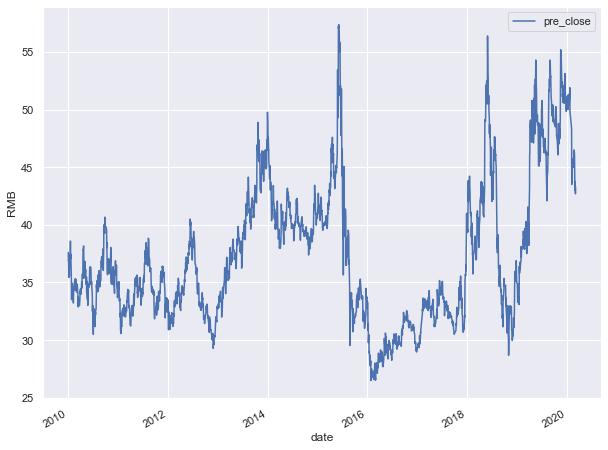

In [57]:
df=df.rename(columns={'trade_date':'date'})
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = df.plot(x='date', y='pre_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("RMB")

In [58]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df.iloc[:num_train,:-1]
cv = df.iloc[num_train:num_train+num_cv,:-1]
train_cv = df.iloc[:num_train+num_cv,:-1]
test = df.iloc[num_train+num_cv:,:-1]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 1479
num_cv = 492
num_test = 492
train.shape = (1479, 7)
cv.shape = (492, 7)
train_cv.shape = (1971, 7)
test.shape = (492, 7)


In [59]:
# Converting dataset into x_train and y_train
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler_train = StandardScaler()
train_scaled = scaler_train.fit_transform(train.iloc[:,1:])
print("scaler.mean_ = " + str(scaler_train.mean_))
print("scaler.var_ = " + str(scaler_train.var_))

# Split into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) 
print("y_train_scaled.shape = " + str(y_train_scaled.shape))

#scaler_train.inverse_transform(train_scaled)

scaler.mean_ = [3.70158891e+01 3.75508181e+01 3.64952468e+01 3.70637255e+01
 3.70693915e+01 3.70390064e+04]
scaler.var_ = [2.14454840e+01 2.27689830e+01 2.02479533e+01 2.15419882e+01
 2.14735976e+01 1.11069892e+09]
x_train_scaled.shape = (1474, 5, 6)
y_train_scaled.shape = (1474, 1)


In [60]:
scaler_cv = StandardScaler()
cv_scaled = scaler_cv.fit_transform(cv.iloc[:,1:])
print("scaler.mean_ = " + str(scaler_cv.mean_))
print("scaler.var_ = " + str(scaler_cv.var_))

# Split into x and y
x_cv_scaled, y_cv_scaled = get_x_y(cv_scaled, N, N)
y_cv=[]
data=cv.iloc[:,1:].copy()
#data.reset_index(inplace=True,drop=True)
data=data.values

for i in range(N, len(data)):
    y_cv.append(data[i,4])  # pre_close
y_cv = np.array(y_cv)
y_cv=y_cv.reshape(-1,1)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape)) 
print("y_cv.shape = " + str(y_cv.shape))

scaler.mean_ = [3.19385163e+01 3.23103252e+01 3.16054878e+01 3.19892073e+01
 3.19651423e+01 3.39406196e+04]
scaler.var_ = [9.59490694e+00 1.05376377e+01 8.96265647e+00 9.80376949e+00
 9.76410181e+00 7.97480809e+08]
x_cv_scaled.shape = (487, 5, 6)
y_cv.shape = (487, 1)


In [61]:
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(train_cv.iloc[:,1:])
print("scaler.mean_ = " + str(scaler_final.mean_))
print("scaler.var_ = " + str(scaler_final.var_))

scaler.mean_ = [3.57484779e+01 3.62426890e+01 3.52746677e+01 3.57970269e+01
 3.57952714e+01 3.62655887e+04]
scaler.var_ = [2.33161371e+01 2.48598406e+01 2.19094476e+01 2.34352599e+01
 2.34307237e+01 1.03431175e+09]


# create a test model

In [62]:
# Create the LSTM network
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],x_train_scaled.shape[2])))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob)) # Add dropout with a probability of 0.5
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['accuracy'])
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 5, 50)             11400     
_________________________________________________________________
dropout_29 (Dropout)         (None, 5, 50)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_30 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 49s - loss: 0.0782 - accuracy: 0.0000e+00
Epoch 2/10
 - 49s - loss: 0.0365 - accuracy: 0.0000e+00
Epo

# predict on cv set

In [63]:
# Do prediction
est_scaled = model.predict(x_cv_scaled)
est=est_scaled*scaler_cv.var_[num_feature]+scaler_cv.mean_[num_feature]
print("est.shape = " + str(est.shape))
# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_pct_bef_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f%%" % mape_pct_bef_tuning)

est.shape = (487, 1)
RMSE = 5.809
MAPE = 13.551%


Text(0, 0.5, 'USD')

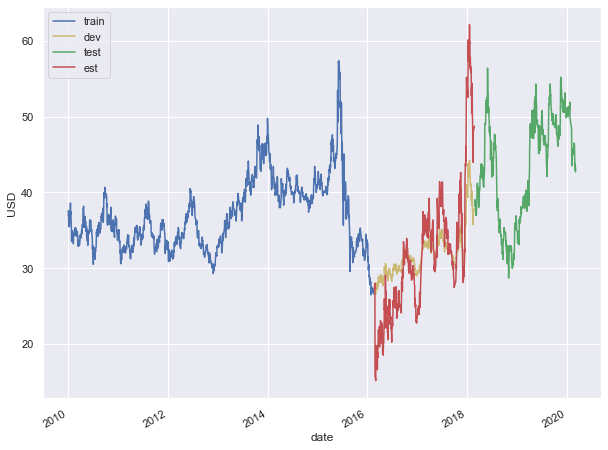

In [64]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
est_r=est.reshape(-1)
m=cv[:num_feature+1]['pre_close'].values
est_r=np.hstack((m,est_r))

est_df = pd.DataFrame({'est': est_r, 
                       'date': cv['date']})

ax = train.plot(x='date', y='pre_close', style='b-', grid=True)
ax = cv.plot(x='date', y='pre_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='pre_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'est'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Tuning N (Number of days)

In [65]:
param_label = 'N'
param_list = range(3,15)

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    x_train_scaled, y_train_scaled = get_x_y(train_scaled, param, param)
    
    
    scaler_train_cv = StandardScaler()
    train_cv_scaled = scaler_train_cv.fit_transform(train_cv.iloc[:,1:])
    x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled, param, param)
    
    
    y_train_cv=[]
    data=train_cv.iloc[:,1:].copy()
    data=data.values
    for i in range(param, len(data)):
        y_train_cv.append(data[i,num_feature])  # pre_close
    y_train_cv = np.array(y_train_cv)
    y_train_cv=y_train_cv.reshape(-1,1)
    
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_train_cv_scaled, \
                                          y_train_cv, \
                                          scaler_train_cv,
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=epochs, \
                                          batch_size=batch_size)
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate

Epoch 1/10
1476/1476 [==============================] - 37s 25ms/step - loss: 0.0817 - accuracy: 0.0000e+008s - loss: 0.0901  -
Epoch 2/10
1476/1476 [==============================] - 37s 25ms/step - loss: 0.0261 - accuracy: 0.0000e+00
Epoch 3/10
1476/1476 [==============================] - 37s 25ms/step - loss: 0.0154 - accuracy: 0.0000e+00
Epoch 4/10
1476/1476 [==============================] - 37s 25ms/step - loss: 0.0163 - accuracy: 0.0000e+00
Epoch 5/10
1476/1476 [==============================] - 38s 26ms/step - loss: 0.0132 - accuracy: 0.0000e+001s - loss: 0.0135 - accuracy: 0.
Epoch 6/10
1476/1476 [==============================] - 37s 25ms/step - loss: 0.0116 - accuracy: 0.0000e+00
Epoch 7/10
1476/1476 [==============================] - 35s 24ms/step - loss: 0.0124 - accuracy: 0.0000e+00
Epoch 8/10
1476/1476 [==============================] - 36s 24ms/step - loss: 0.0109 - accuracy: 0.0000e+00
Epoch 9/10
1476/1476 [==============================] - 37s 25ms/step - loss: 0.0102

,N,rmse,mape_pct
0,3,18.591481,39.338937
1,4,18.502533,40.670550
2,5,19.055135,41.905465
3,6,19.928533,44.285349
4,7,17.754503,39.912763
5,8,17.591878,38.635873
6,9,18.002722,40.355484
7,10,18.658823,42.439518
8,11,18.734305,41.770886
9,12,17.432610,39.447745


Text(0, 0.5, 'RMSE/MAPE(%)')

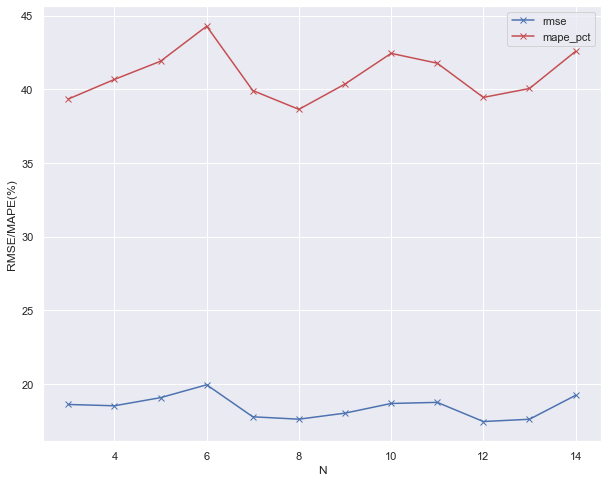

In [66]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='N', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='N', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE/MAPE(%)")

In [67]:
# Get optimum value for param
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
N_opt = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(N_opt))

min RMSE = 17.433
min MAPE = 38.636%
optimum N = 12


# Tuning model - epochs and batch_size

In [72]:
param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param2_label = 'batch_size'
param2_list = [8, 16, 32, 64, 128]

# Split train into x and y
x_train_scaled, y_train_scaled = get_x_y(train_scaled, N_opt, N_opt)

scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv.iloc[:,1:])
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled, N_opt, N_opt)

y_train_cv=[]
train_cv.reset_index(inplace=True,drop=True)
data=train_cv.iloc[N_opt-1:,1:].copy()
data=data.values

for i in range(param, len(data)):
    y_train_cv.append(data[i,num_feature])  # pre_close
y_train_cv = np.array(y_train_cv)
y_train_cv=y_train_cv.reshape(-1,1)

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()

print(x_train_cv_scaled.shape,y_train_cv_scaled.shape,y_train_cv.shape)

for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
        
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_train_cv_scaled, \
                                          y_train_cv, \
                                          scaler_train_cv,
                                          lstm_units=lstm_units, \
                                          dropout_prob=dropout_prob, \
                                          optimizer=optimizer, \
                                          epochs=param, \
                                          batch_size=param2)
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate  

(1959, 12, 6) (1959, 1) (1959, 1)


Epoch 1/1
1467/1467 [==============================] - 11s 8ms/step - loss: 0.1472 - accuracy: 0.0000e+00
1467 1959
Epoch 1/1
1467/1467 [==============================] - 7s 5ms/step - loss: 0.1524 - accuracy: 0.0000e+00
1467 1959
Epoch 1/1
1467/1467 [==============================] - 4s 3ms/step - loss: 0.2330 - accuracy: 0.0000e+00
1467 1959
Epoch 1/1
1467/1467 [==============================] - 3s 2ms/step - loss: 0.3292 - accuracy: 0.0000e+00
1467 1959
Epoch 1/1
1467/1467 [==============================] - 2s 2ms/step - loss: 0.3662 - accuracy: 0.0000e+00
1467 1959



Epoch 1/10
1467/1467 [==============================] - 12s 8ms/step - loss: 0.1135 - accuracy: 0.0000e+00
Epoch 2/10
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0497 - accuracy: 0.0000e+00
Epoch 3/10
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0342 - accuracy: 0.0000e+00 0s - loss: 0.0345 - accuracy: 0.00
Epoch 4/10
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0330 - accuracy: 0.0000e+00
Epoch 5/10
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0218 - accuracy: 0.0000e+00
Epoch 6/10
1467/1467 [==============================] - 11s 7ms/step - loss: 0.0187 - accuracy: 0.0000e+00 0s - loss: 0.0189 - accu
Epoch 7/10
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0156 - accuracy: 0.0000e+00
Epoch 8/10
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0130 - accuracy: 0.0000e+00
Epoch 9/10
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0131 

Epoch 1/20
1467/1467 [==============================] - 12s 8ms/step - loss: 0.1187 - accuracy: 0.0000e+00
Epoch 2/20
1467/1467 [==============================] - 9s 6ms/step - loss: 0.0480 - accuracy: 0.0000e+00: 0s - loss: 0.0485 - accuracy
Epoch 3/20
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0395 - accuracy: 0.0000e+00 0s - loss: 0.0393 - 
Epoch 4/20
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0330 - accuracy: 0.0000e+00
Epoch 5/20
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0247 - accuracy: 0.0000e+00
Epoch 6/20
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0179 - accuracy: 0.0000e+00
Epoch 7/20
1467/1467 [==============================] - 9s 6ms/step - loss: 0.0167 - accuracy: 0.0000e+00
Epoch 8/20
1467/1467 [==============================] - 9s 6ms/step - loss: 0.0139 - accuracy: 0.0000e+00
Epoch 9/20
1467/1467 [==============================] - 9s 6ms/step - loss: 0.0111 - accuracy: 0

Epoch 1/30
1467/1467 [==============================] - 12s 8ms/step - loss: 0.1218 - accuracy: 0.0000e+00
Epoch 2/30
1467/1467 [==============================] - 9s 6ms/step - loss: 0.0536 - accuracy: 0.0000e+00: 0s - loss:
Epoch 3/30
1467/1467 [==============================] - 11s 7ms/step - loss: 0.0364 - accuracy: 0.0000e+00
Epoch 4/30
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0295 - accuracy: 0.0000e+00
Epoch 5/30
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0252 - accuracy: 0.0000e+00
Epoch 6/30
1467/1467 [==============================] - 11s 7ms/step - loss: 0.0203 - accuracy: 0.0000e+00
Epoch 7/30
1467/1467 [==============================] - 11s 7ms/step - loss: 0.0157 - accuracy: 0.0000e+00
Epoch 8/30
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0138 - accuracy: 0.0000e+00
Epoch 9/30
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0142 - accuracy: 0.0000e+00
Epoch 10/30
1467/1467 [===

Epoch 1/40
1467/1467 [==============================] - 13s 9ms/step - loss: 0.1152 - accuracy: 0.0000e+00
Epoch 2/40
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0468 - accuracy: 0.0000e+00
Epoch 3/40
1467/1467 [==============================] - 12s 8ms/step - loss: 0.0360 - accuracy: 0.0000e+00
Epoch 4/40
1467/1467 [==============================] - 9s 6ms/step - loss: 0.0291 - accuracy: 0.0000e+00: 1s - l
Epoch 5/40
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0260 - accuracy: 0.0000e+00
Epoch 6/40
1467/1467 [==============================] - 10s 7ms/step - loss: 0.0207 - accuracy: 0.0000e+00
Epoch 7/40
1467/1467 [==============================] - 11s 7ms/step - loss: 0.0147 - accuracy: 0.0000e+00 0s - loss: 0.014
Epoch 8/40
1467/1467 [==============================] - 9s 6ms/step - loss: 0.0125 - accuracy: 0.0000e+00: 1s
Epoch 9/40
1467/1467 [==============================] - 11s 7ms/step - loss: 0.0113 - accuracy: 0.0000e+00
Epoch 10/4

1467/1467 [==============================] - 2s 1ms/step - loss: 0.0158 - accuracy: 0.0000e+00
Epoch 30/40
1467/1467 [==============================] - 2s 1ms/step - loss: 0.0134 - accuracy: 0.0000e+00
Epoch 31/40
1467/1467 [==============================] - 2s 1ms/step - loss: 0.0145 - accuracy: 0.0000e+00
Epoch 32/40
1467/1467 [==============================] - 2s 1ms/step - loss: 0.0157 - accuracy: 0.0000e+00
Epoch 33/40
1467/1467 [==============================] - 2s 1ms/step - loss: 0.0128 - accuracy: 0.0000e+00
Epoch 34/40
1467/1467 [==============================] - 2s 1ms/step - loss: 0.0118 - accuracy: 0.0000e+00
Epoch 35/40
1467/1467 [==============================] - 2s 1ms/step - loss: 0.0115 - accuracy: 0.0000e+00
Epoch 36/40
1467/1467 [==============================] - 2s 1ms/step - loss: 0.0116 - accuracy: 0.0000e+00
Epoch 37/40
1467/1467 [==============================] - 2s 1ms/step - loss: 0.0106 - accuracy: 0.0000e+00
Epoch 38/40
1467/1467 [==========================

Epoch 1/50
1467/1467 [==============================] - 14s 10ms/step - loss: 0.1266 - accuracy: 0.0000e+00
Epoch 2/50
1467/1467 [==============================] - 12s 8ms/step - loss: 0.0528 - accuracy: 0.0000e+00
Epoch 3/50
1467/1467 [==============================] - 12s 8ms/step - loss: 0.0364 - accuracy: 0.0000e+00
Epoch 4/50
1467/1467 [==============================] - 12s 8ms/step - loss: 0.0310 - accuracy: 0.0000e+00
Epoch 5/50
1467/1467 [==============================] - 12s 8ms/step - loss: 0.0242 - accuracy: 0.0000e+00
Epoch 6/50
1467/1467 [==============================] - 12s 8ms/step - loss: 0.0195 - accuracy: 0.0000e+00
Epoch 7/50
1467/1467 [==============================] - 12s 8ms/step - loss: 0.0149 - accuracy: 0.0000e+00
Epoch 8/50
1467/1467 [==============================] - 12s 8ms/step - loss: 0.0139 - accuracy: 0.0000e+00
Epoch 9/50
1467/1467 [==============================] - 13s 9ms/step - loss: 0.0126 - accuracy: 0.0000e+00
Epoch 10/50
1467/1467 [=============

Epoch 26/50
1467/1467 [==============================] - 6s 4ms/step - loss: 0.0059 - accuracy: 0.0000e+00
Epoch 27/50
1467/1467 [==============================] - 6s 4ms/step - loss: 0.0076 - accuracy: 0.0000e+00
Epoch 28/50
1467/1467 [==============================] - 6s 4ms/step - loss: 0.0071 - accuracy: 0.0000e+00
Epoch 29/50
1467/1467 [==============================] - 7s 4ms/step - loss: 0.0082 - accuracy: 0.0000e+00
Epoch 30/50
1467/1467 [==============================] - 6s 4ms/step - loss: 0.0075 - accuracy: 0.0000e+00
Epoch 31/50
1467/1467 [==============================] - 6s 4ms/step - loss: 0.0061 - accuracy: 0.0000e+00
Epoch 32/50
1467/1467 [==============================] - 6s 4ms/step - loss: 0.0049 - accuracy: 0.0000e+00
Epoch 33/50
1467/1467 [==============================] - 6s 4ms/step - loss: 0.0053 - accuracy: 0.0000e+00
Epoch 34/50
1467/1467 [==============================] - 6s 4ms/step - loss: 0.0051 - accuracy: 0.0000e+00
Epoch 35/50
1467/1467 [==============

1467/1467 [==============================] - 1s 585us/step - loss: 0.0274 - accuracy: 0.0000e+00
Epoch 29/50
1467/1467 [==============================] - 1s 564us/step - loss: 0.0267 - accuracy: 0.0000e+00
Epoch 30/50
1467/1467 [==============================] - 1s 585us/step - loss: 0.0263 - accuracy: 0.0000e+00
Epoch 31/50
1467/1467 [==============================] - 1s 590us/step - loss: 0.0279 - accuracy: 0.0000e+00
Epoch 32/50
1467/1467 [==============================] - 1s 587us/step - loss: 0.0254 - accuracy: 0.0000e+00
Epoch 33/50
1467/1467 [==============================] - 1s 613us/step - loss: 0.0236 - accuracy: 0.0000e+00
Epoch 34/50
1467/1467 [==============================] - 1s 542us/step - loss: 0.0234 - accuracy: 0.0000e+00
Epoch 35/50
1467/1467 [==============================] - 1s 596us/step - loss: 0.0229 - accuracy: 0.0000e+00
Epoch 36/50
1467/1467 [==============================] - 1s 589us/step - loss: 0.0219 - accuracy: 0.0000e+00
Epoch 37/50
1467/1467 [========

,epochs,batch_size,rmse,mape_pct
0,1,8,19.566217,43.775565
1,1,16,18.421079,42.169575
2,1,32,18.358995,44.178400
3,1,64,15.631080,39.713188
4,1,128,22.524067,56.589494
5,10,8,19.286539,43.308594
6,10,16,19.051778,43.629709
7,10,32,19.030423,42.706016
8,10,64,18.585817,41.256761
9,10,128,17.117780,38.592969


In [71]:
print(x_train_cv_scaled.shape,y_train_cv_scaled.shape,y_train_cv.shape)

(1959, 12, 6) (1959, 1) (1970, 1)


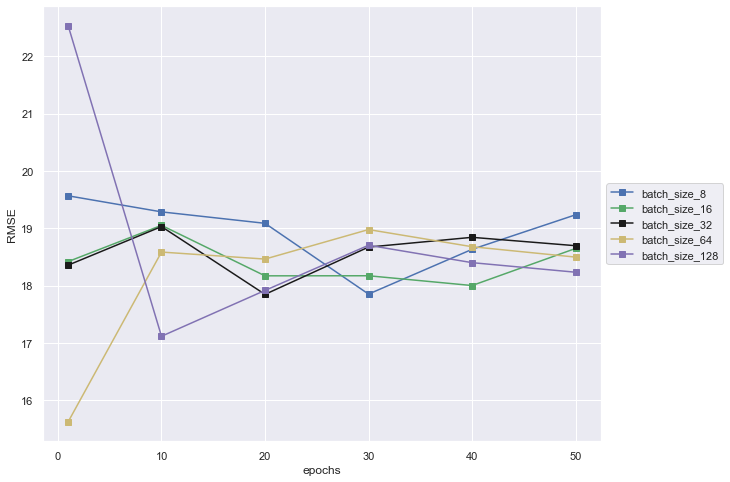

In [73]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [74]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

min RMSE = 15.631
min MAPE = 38.593%
optimum epochs = 1
optimum batch_size = 64


# Tuning model - LSTM units and dropout prob

In [ ]:
param_label = 'lstm_units'
param_list = [10, 50, 64, 128]

param2_label = 'dropout_prob'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [], param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
    
    for param2 in tqdm_notebook(param2_list):
    
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_train_cv_scaled, \
                                          y_train_cv, \
                                          scaler_train_cv,
                                          lstm_units=param, \
                                          dropout_prob=param2, \
                                          optimizer=optimizer, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

In [ ]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
lstm_units_opt = temp[param_label].values[0]
dropout_prob_opt = temp[param2_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(lstm_units_opt))
print("optimum " + param2_label + " = " + str(dropout_prob_opt))

# Tuning model - optimizer

In [ ]:
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']

error_rate = {param_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
   
    # Train, predict and eval model
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, \
                                          y_train_scaled, \
                                          x_train_cv_scaled, \
                                          y_train_cv, \
                                          scaler_train_cv,
                                          lstm_units=lstm_units_opt, \
                                          dropout_prob=dropout_prob_opt, \
                                          optimizer=param, \
                                          epochs=epochs_opt, \
                                          batch_size=batch_size_opt)
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

In [ ]:
# Plot RMSE 
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = error_rate.plot(x='optimizer', y='rmse', style='bx-', grid=True)
ax = error_rate.plot(x='optimizer', y='mape_pct', style='rx-', grid=True, ax=ax)
ax.set_xticklabels(param_list)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE/MAPE(%)")

In [ ]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
optimizer_opt = temp[param_label].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum " + param_label + " = " + str(optimizer_opt))

# Turned params

In [ ]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'original': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bef_tuning, mape_pct_bef_tuning],
     'after_tuning': [N_opt, lstm_units_opt, dropout_prob_opt, optimizer_opt, epochs_opt, batch_size_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

# Final model

In [ ]:
# Split train_cv into x and y
x_train_cv_scaled, y_train_cv_scaled = get_x_y(train_cv_scaled_final, N_opt, N_opt)

# Split test into x and y
scaler_test = StandardScaler()
test_scaled = scaler_test.fit_transform(test.iloc[:,1:])
print("scaler.mean_ = " + str(scaler_test.mean_))
print("scaler.var_ = " + str(scaler_test.var_))
x_test_scaled, y_test_scaled = get_x_y(test_scaled, N_opt, N_opt)

y_test=[]
test.reset_index(inplace=True,drop=True)
data=test.iloc[N_opt-1:,1:].copy()
data=data.values

for i in range(N, len(data)):
    y_test.append(data[i,num_feature])  # pre_close
y_test = np.array(y_cv)
y_test=y_test.reshape(-1,1)


# Train, predict and eval model
rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, \
                                        y_train_cv_scaled, \
                                        x_test_scaled, \
                                        y_test, \
                                        mu_test_list, \
                                        std_test_list, \
                                        lstm_units=lstm_units_opt, \
                                        dropout_prob=dropout_prob_opt, \
                                        optimizer=optimizer_opt, \
                                        epochs=epochs_opt, \
                                        batch_size=batch_size_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[num_train+num_cv:]['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [ ]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 1), date(2018, 11, 30)])
ax.set_ylim([130, 155])
ax.set_title("Zoom in to test set")

In [ ]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using lstm'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
ax.set_ylim([130, 155])